### 모델 성능 보다는 모델 해석 중심으로 
### 이론적인 내용은 https://huidea.tistory.com/246 참고 

##    0. import module

In [ ]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd 
import scipy as sp 
import statsmodels.api as sm 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. data load & split

In [ ]:
def data_load_split():

    ### 1. data load 
    boston = load_boston()

    ### 2. setting X, Y variable    
    X = pd.DataFrame(boston.data, columns = boston.feature_names)
    Y = pd.DataFrame(boston.target, columns = ['MEDV'])

    ### 3. train, test data split 
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2022)
    return X, Y, X_train, X_test, y_train, y_test

In [ ]:
## data load & split 
X, Y, X_train, X_test, y_train, y_test = data_load_split()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## 2. modeling - using stats ols

In [ ]:
X_train = sm.add_constant(X_train) ### 선형 회귀 식의 beta 0를 만드는 과정 
model = sm.OLS(y_train, X_train, axis = 1) ## OLS data modeling 
model_trained = model.fit() ## 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 3. 선형 회귀 모델 가정 확인

선형 회귀의 가정 - 정규성, 등분상성, 독립성 


### 확률 오차의 정규성
* 잔차 (타겟값 - 예측값) 이 정규성을 따르는지 확인
* 시각화 분석 : QQ plot, 히스토그램
* 수치 분석 : 샤피로 검정, Jarque-Bera 검정

#### QQplot, histogram

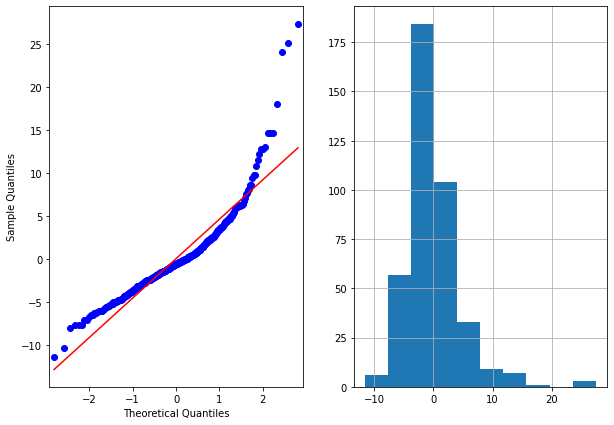

In [ ]:
model_residuals = model_trained.resid ### 모델의 잔차(예측값 - 타겟값)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sm.ProbPlot(model_residuals).qqplot(line = 's', ax = ax1)
ax2 = model_residuals.hist()
# ax.title.set_text('QQplot')

* 위 그림을 통해 봤을 때, 직선안에 모여있지 않은 이상점들이 몇개 보임
* 데이터가 정규분포를 따른다고 보기 어려움

#### 샤피로 검정

In [ ]:
import scipy as sp 
model_residuals = model_trained.resid 
sp.stats.shapiro(model_residuals)

(0.8728269338607788, 1.0728708734283243e-17)

### 등분산성, 독립성 확인 - residual plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


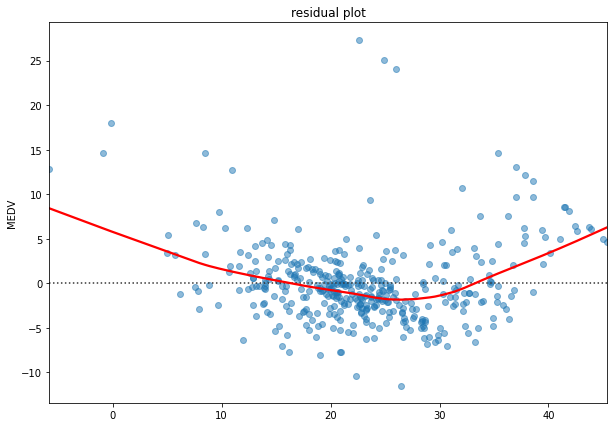

In [ ]:
### residual plot 

model_fitted_y = model_trained.fittedvalues ## 예측값

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1, 1, 1)

sns.residplot(model_fitted_y, y_train, data = X_train, lowess= True, scatter_kws = {'alpha' : 0.5}, line_kws = {'color':'red'}, ax = ax1)
ax1.title.set_text('residual plot')


[ 등분산성 ] : 예측값과 상관없이 오차의 모든 분산이 동일하다는 가정
* yhat 이 커짐에 따라 잔차 값이 변화함 
* 위의 형태처럼 곡선 형태인 경우, 비정상적인 Residual plot 
* 빨간색 실선이 수평을 그리는 것이 이상적

[ 예측값과 잔차간의 독립성 ] 
* 무작위로 퍼져있지 않고 한 곳에 모여있음 
* 예측값과 잔차간의 독립성 이 수립한다고 하기 어려움

### 잔차(의 독립성 - durbin watson

* durbin watson 자기 상관계수 확인
* D-W Statistic 값은 0 ~ 4의 값을 가짐 
* 0으로 가까울 수록 (잔차의) 양의 상관관계 
* 4에 가까울수록 음의 상관관계, 2는 독립 
* 여기서의 p_value는 자기상관성에 대한 것인데 기각역보다 작다면 자기상관관계가 있다고 해석하는 것 



In [ ]:
sm.stats.stattools.durbin_watson(model_residuals)

1.8929390085478452

* 1.8이므로 잔차간의 독립은 맞음 

### 독립변수와 잔차간의 독립성
* 독립변수와 잔차간의 상관계수, 산점도로 확인

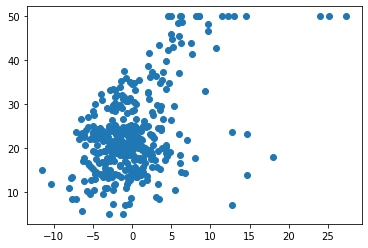

[[1.         0.49387933]
 [0.49387933 1.        ]]


In [ ]:
plt.scatter(model_residuals, y_train)
plt.show()

print(np.corrcoef(model_residuals.values,np.array(y_train).flatten()))

* 산포도에서도 상관관계가 보이지는 않음
* 상관계수도 0.49로 강한 상관관계는 아님

## 결과 해석

* R-squared value : 모형의 성능
* coff (회귀계수) : X가 한단위 증가할때 Y의 변화량 
* 각 변수의 pvalue 

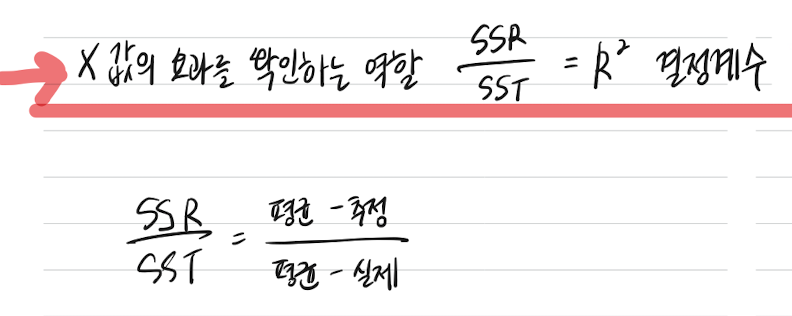

In [ ]:
print(model_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     92.99
Date:                Sun, 20 Feb 2022   Prob (F-statistic):          1.06e-110
Time:                        09:07:48   Log-Likelihood:                -1188.8
No. Observations:                 404   AIC:                             2406.
Df Residuals:                     390   BIC:                             2462.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.6150      5.691      4.853      0.0

* coef : 각 변수별 계수 추정치 
* const : y절편 (beta0)
* std err : 계수 추정치의 표준편차
* t : t검정 통계량 값 
((점추정 값 - 귀무가설 0) / 표준편차)

    → 즉, t값이 크면 추정된 계수가 0이 아니라는 것

    → 귀무가설 기각 


* Rsquare - 0.756

* pvalue가 0.1보다 큰 경우 귀무가설 통과


    → 여기서 귀무가설은 "X(독립변수)의 계수(b1)가 0이다"

    → 즉 pvalue가 0.1보다 큰 독립변수의 계수는 0이다.

    → age, indus 는 유의하지 않다고 해석가능 

### pvalue 0.1 이상인 독립변수 제거

In [ ]:
model = sm.OLS(y_train, X_train.drop(['INDUS','AGE'], axis = 1), axis = 1) ## OLS data modeling 
model_trained2 = model.fit() 
y_train_pred = model_trained2.fittedvalues

In [ ]:
print(model_trained2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sun, 20 Feb 2022   Prob (F-statistic):          1.70e-112
Time:                        09:28:50   Log-Likelihood:                -1189.4
No. Observations:                 404   AIC:                             2403.
Df Residuals:                     392   BIC:                             2451.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.9061      5.659      4.931      0.0

### 예측값 타겟값 plotting

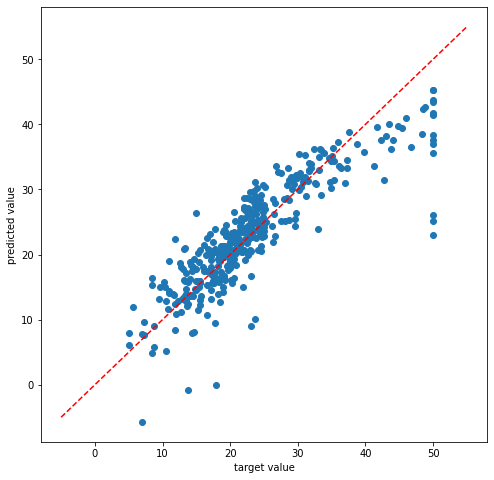

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_train, y_train_pred)
plt.plot([-5,55],[-5,55], ls= '--', c='red')
plt.xlabel("target value")
plt.ylabel("predicted value")
plt.show()

### X_test의 MAE, MSE, RMSE, MAPE, R2score 보기

In [ ]:
X_test = sm.add_constant(X_test)
y_test_pred = model_trained2.predict(X_test.drop(['INDUS','AGE'], axis = 1))
y_test_pred.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


104    21.453359
406     6.566851
487    21.202302
276    36.065375
422    18.112821
dtype: float64

In [ ]:
### MAE, mse, rmse 

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = MAPE(y_test['MEDV'].values, y_test_pred.values.flatten())

print("mae",mae)
print("mse",mse)
print("rmse",rmse)
print("mape",mape)
print("r2 score", r2_score(y_test, y_test_pred))

mae 3.870691814228746
mse 26.472312430702235
rmse 5.145125113221469
mape 23.13939905272082
r2 score 0.62973282146263


* R2 score 가 0.62라는 건 

→ 현재 분석이 사용하고 있는 변수의 품질이 62점 정도라는 것

→ 변수들에 의해 

